# RELU neural nets and tropical geometry
I was reading the paper _Tropical Geometry of Deep Neural Networks_ by Zhang, Naitzat, and Lim (https://arxiv.org/abs/1805.07091). The tl;dr is that every feed-forward RELU network with integer coefficients is exactly a tropical rational map.

Short summary, based on a semester-long graduate seminar years ago: Tropical geometry is a combinatorial analogue of algebraic geometry. One does tropical geometry by taking regular algebra and "tropifying" by making the following replacements:
  - a+b \to max{a,b} 
  - ab \to a+b.
  - a/b \to a-b
Tropical geometry is like algebraic geometry (never my forte), but instead of algebraic varieties, the associated geometric objects are polytopes. Tropical polynomials are continuous piecewise-linear functions. Because much of the formal algebra carries over under "tropification", I guess the idea behind tropical geometry is to learn about complicated algebraic varieties from combinatorial study of polytopes.

Enter relu neural nets. It's safe to assume that the weights in each neuron are rational, and because scaling each weight doesn't change the output of the model, we may as well assume the weights are integers. By combining and composing relu activations with affine-linear functions, the authors prove that relu neural nets are just complicated piecewise linear functions.

I decided to test this out for myself.

In [1]:
import numpy as np
import pandas as pd
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 8)

Using TensorFlow backend.


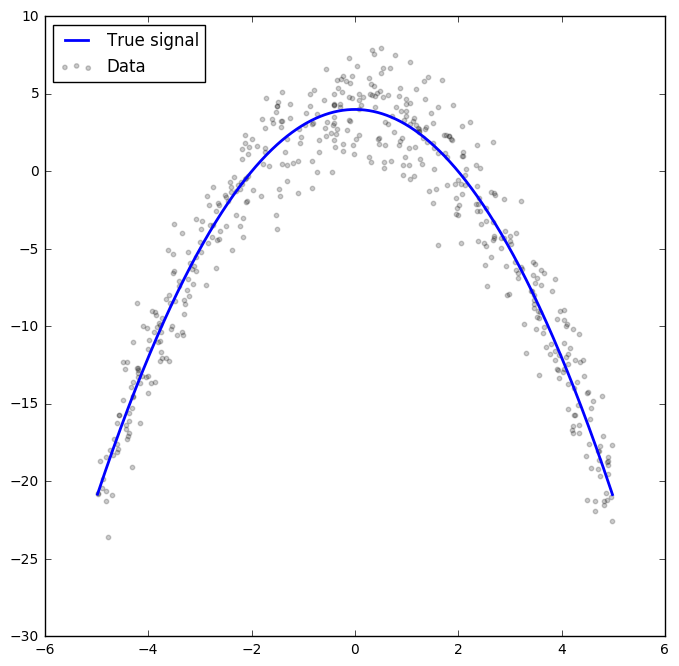

In [2]:
def true_signal(x):
    return -(x - 2)*(x + 2)
x = 10*(np.random.random(500) - 0.5)
y = true_signal(x) + 2*np.random.randn(len(x))

x_scan = np.linspace(np.min(x), np.max(x), 10000)

fig, ax = plt.subplots()
ax.scatter(x, y, s=10, c="k", alpha=0.2,
           label="Data")
ax.plot(x_scan, true_signal(x_scan), c="blue", lw=2,
        label="True signal")
ax.legend(loc=2)
plt.show()

In [3]:
# keras model
model = Sequential()
model.add(Dense(32, activation="relu", input_shape=(1,)))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="linear"))

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

model.compile(loss="mean_squared_error",
              optimizer="rmsprop")
model.fit(x, y, epochs=100,
          verbose=False)
print("Training successful!")

Training successful!


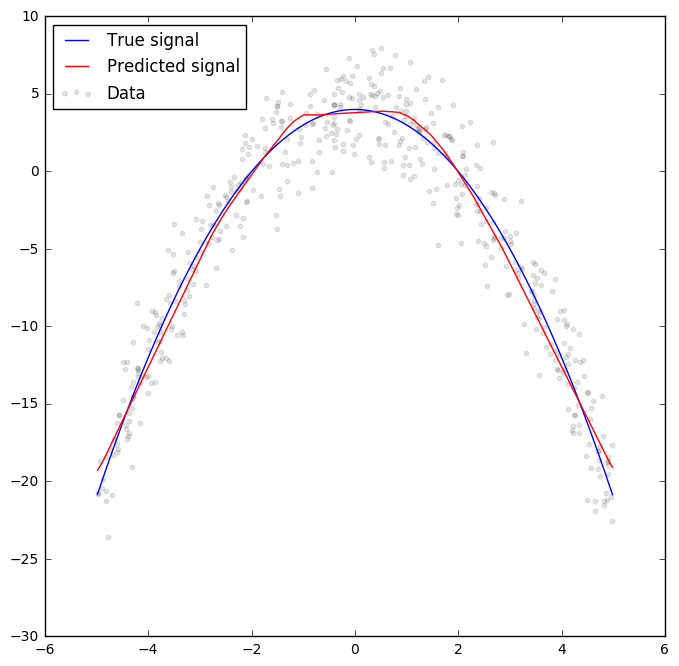

In [4]:
y_pred = model.predict(x_scan)
fig, ax = plt.subplots()
ax.scatter(x, y, s=10, c="k", alpha=0.1,
           label="Data")
ax.plot(x_scan, true_signal(x_scan), c="blue", lw=1,
        label="True signal")
ax.plot(x_scan, y_pred, c="red", lw=1, label="Predicted signal")
ax.legend(loc=2)
plt.show()

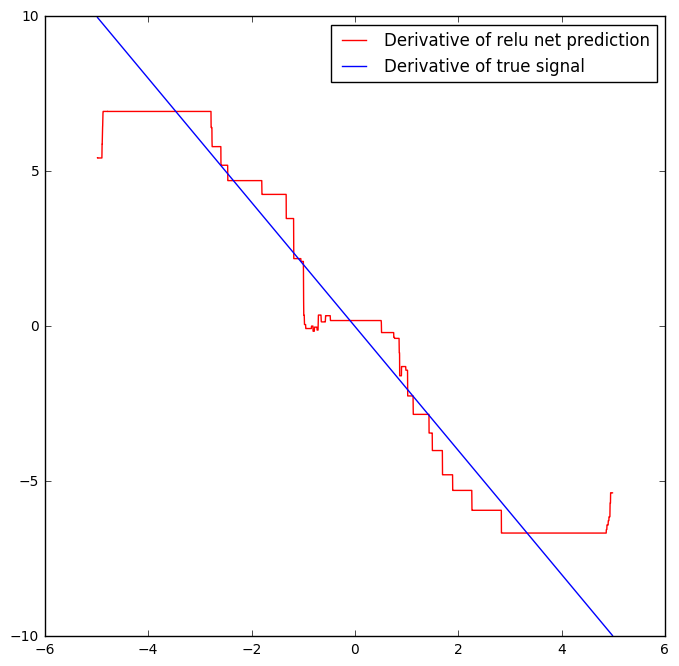

In [5]:
# finite difference derivative...just to see if it's really piecewise linear
dx = (np.max(x) - np.min(x))/10000
dy_pred = np.gradient(y_pred.reshape(len(y_pred)), dx)
dy = np.gradient(true_signal(x_scan), dx)
fig, ax = plt.subplots()
ax.plot(x_scan, dy_pred, color="red", label="Derivative of relu net prediction")
ax.plot(x_scan, dy, color="blue", label="Derivative of true signal")
ax.legend()
plt.show()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  label   No. Observations:                  500
Model:                            GLM   Df Residuals:                      497
Model Family:                Gaussian   Df Model:                            2
Link Function:               identity   Scale:                          4.0801
Method:                          IRLS   Log-Likelihood:                -1059.5
Date:                Sat, 23 Jun 2018   Deviance:                       2027.8
Time:                        12:51:15   Pearson chi2:                 2.03e+03
No. Iterations:                     3   Covariance Type:             nonrobust
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            3.9632      0.136     29.070      0.000       3.696       4.230
cov                  0.0111      0

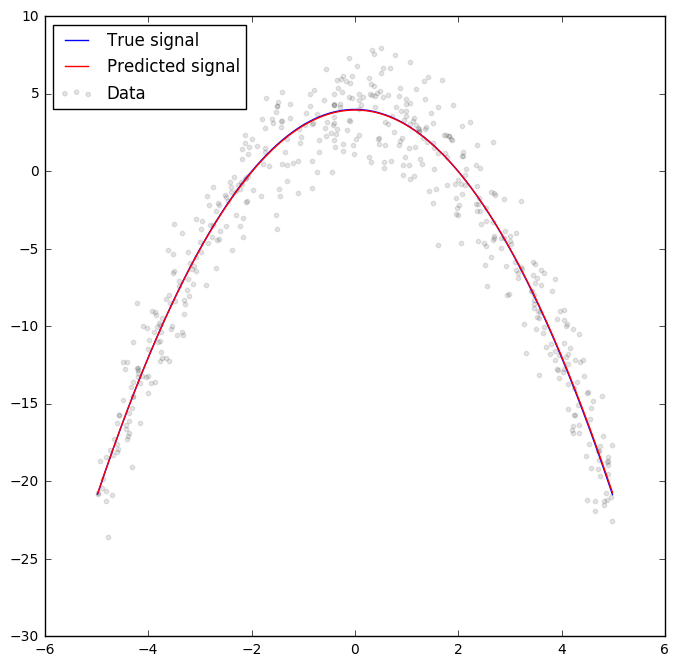

In [6]:
# linear model, just for fun... 
df = pd.DataFrame({"cov": x, "label": y})
formula1 = "label ~ cov + np.power(cov, 2)"
model = smf.glm(data=df, formula=formula1, family=sm.families.Gaussian()).fit()
print(model.summary())

df["pred1"] = model.predict(df)

y_pred = model.predict(pd.DataFrame({"cov": x_scan}))
fig, ax = plt.subplots()
ax.scatter(df["cov"], df["label"], s=10, c="k", alpha=0.1,
           label="Data")
ax.plot(x_scan, true_signal(x_scan), c="blue", lw=1,
        label="True signal")
ax.plot(x_scan, y_pred, c="red", lw=1, label="Predicted signal")
ax.legend(loc=2)
plt.show()